In [1]:
import pandas as pd
import json
from pyspark.sql import functions as F

In [3]:
from pyspark.sql import SparkSession

# Initialize Spark
spark = SparkSession.builder \
    .appName("xT_preprocessing") \
    .config("spark.driver.memory", "8g") \
    .getOrCreate()
spark.conf.set("spark.sql.execution.arrow.pyspark.enabled", "true")

In [4]:
# Load data
df = spark.read.parquet('data/all_events_Italy_2015_2016.parquet')

# Basic info
print(f"Total events: {df.count():,}")
print(f"Columns: {len(df.columns)}")

Total events: 1,353,739
Columns: 116


In [7]:
# Select only needed columns
df_filtered = df.select(
    'match_id',
    'possession',
    'team',
    'possession_team',
    'index',
    'type',
    'location',
    'pass_end_location',
    # 'carry_end_location',
    'shot_outcome'
)

print(f"Columns reduced from {len(df.columns)} to {len(df_filtered.columns)}")
df_filtered.show(10)

Columns reduced from 116 to 9
+--------+----------+--------+---------------+-----+-----------+------------+-----------------+------------+
|match_id|possession|    team|possession_team|index|       type|    location|pass_end_location|shot_outcome|
+--------+----------+--------+---------------+-----+-----------+------------+-----------------+------------+
| 3879863|         1|Atalanta|       Atalanta|    1|Starting XI|        NULL|             NULL|        NULL|
| 3879863|         1| Udinese|       Atalanta|    2|Starting XI|        NULL|             NULL|        NULL|
| 3879863|         1| Udinese|       Atalanta|    3| Half Start|        NULL|             NULL|        NULL|
| 3879863|         1|Atalanta|       Atalanta|    4| Half Start|        NULL|             NULL|        NULL|
| 3879863|        88| Udinese|       Atalanta| 1839| Half Start|        NULL|             NULL|        NULL|
| 3879863|        88|Atalanta|       Atalanta| 1840| Half Start|        NULL|             NULL|   

In [8]:
# Filter movement events only
movement_types = ['Pass', 'Shot']

df_movement = df_filtered.filter(
    df_filtered['type'].isin(movement_types)
)

df_movement = df_movement.filter(
    (F.col("type") != "Shot") | 
    (F.col("shot_type").isNull()) |
    (F.col("shot_type") != "Penalty")
)

print(f"Events before filter: {df_filtered.count():,}")
print(f"Events after filters: {df_movement.count():,}")
print(f"Kept: {df_movement.count() / df_filtered.count() * 100:.1f}%")

# Show distribution
print("\nEvent type distribution:")
df_movement.groupBy('type').count().orderBy('count', ascending=False).show()

Events before filter: 1,353,739
Events after filters: 383,544
Kept: 28.3%

Event type distribution:
+----+------+
|type| count|
+----+------+
|Pass|373667|
|Shot|  9877|
+----+------+



In [36]:
df_movement.filter(col("shot_outcome")=="Goal").count()

858

In [9]:
from pyspark.sql import functions as F

df_movement = df_movement.withColumn(
    "location",
    F.when(
        F.col("team") != F.col("possession_team"),
        F.array(
            F.round(F.lit(120) - F.col("location")[0], 1),
            F.round(F.lit(80) - F.col("location")[1], 1)
        )
    ).otherwise(F.col("location"))
).withColumn(
    "pass_end_location",
    F.when(
        F.col("team") != F.col("possession_team"),
        F.array(
            F.round(F.lit(120) - F.col("pass_end_location")[0], 1),
            F.round(F.lit(80) - F.col("pass_end_location")[1], 1)
        )
    ).otherwise(F.col("pass_end_location"))
)

In [10]:
from pyspark.sql.functions import col
df_movement.filter((col('match_id')==3879863) &(col('possession')==2)).orderBy("index").show()

+--------+----------+--------+---------------+-----+----+------------+-----------------+------------+
|match_id|possession|    team|possession_team|index|type|    location|pass_end_location|shot_outcome|
+--------+----------+--------+---------------+-----+----+------------+-----------------+------------+
| 3879863|         2|Atalanta|       Atalanta|    5|Pass|[61.0, 40.1]|     [58.7, 42.1]|        NULL|
| 3879863|         2|Atalanta|       Atalanta|    8|Pass|[57.6, 42.1]|     [35.5, 46.4]|        NULL|
| 3879863|         2|Atalanta|       Atalanta|   11|Pass|[37.3, 46.2]|     [78.1, 10.2]|        NULL|
| 3879863|         2| Udinese|       Atalanta|   13|Pass|[78.0, 10.1]|     [67.3, 40.3]|        NULL|
| 3879863|         2| Udinese|       Atalanta|   15|Pass|[66.7, 40.3]|     [66.0, 46.5]|        NULL|
| 3879863|         2|Atalanta|       Atalanta|   25|Pass|[76.0, 75.7]|     [84.7, 71.2]|        NULL|
| 3879863|         2|Atalanta|       Atalanta|   29|Pass|[81.5, 71.0]|     [65.5, 

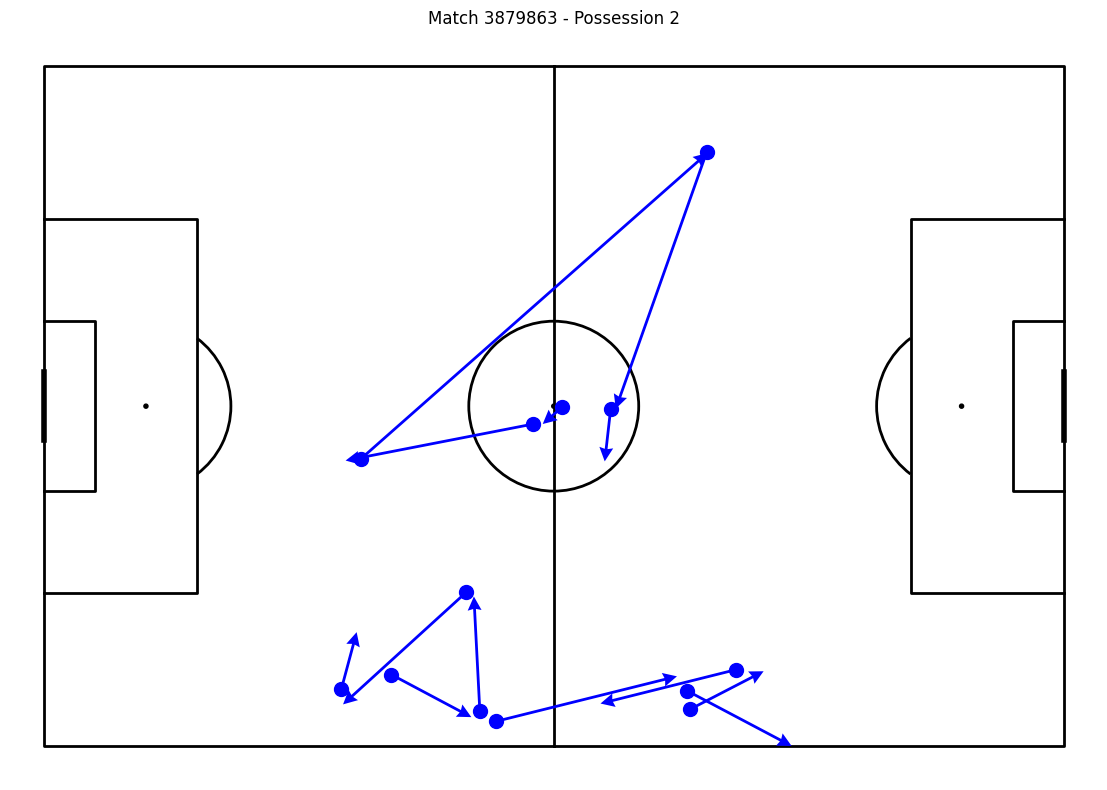

In [11]:
from mplsoccer import Pitch
import matplotlib.pyplot as plt

# Filtruj po match_id i possession
match_id = 3879863  # twoje match_id
possession_num = 2
df_action = df_movement.filter(
    (df_movement.match_id == match_id) & (df_movement.possession == possession_num)
).orderBy('index').toPandas()

pitch = Pitch(pitch_type='statsbomb', line_color='black', pitch_color='white')
fig, ax = pitch.draw(figsize=(12, 8))

colors = {'Pass': 'blue', 'Carry': 'grey', 'Shot': 'red'}

for idx, row in df_action.iterrows():
    event_type = row['type']
    start = row['location']
    
    # Pobierz end_location
    end = row['pass_end_location']

    
    # Sprawdź czy end istnieje (None sprawdza się normalnie)
    if end is None:
        continue
    
    # Strzałka
    pitch.arrows(start[0], start[1], end[0], end[1],
                 ax=ax, color=colors.get(event_type, 'gray'),
                 width=2, headwidth=5, headlength=5)
    
    # Punkt startowy
    pitch.scatter(start[0], start[1], ax=ax, 
                  color=colors.get(event_type, 'gray'), 
                  s=100, zorder=3)

# Shot marker
shots = df_action[df_action['type'] == 'Shot']
if not shots.empty:
    for _, shot in shots.iterrows():
        pitch.scatter(shot['location'][0], shot['location'][1],
                     ax=ax, color='red', s=300, 
                     marker='*', zorder=4)

plt.title(f'Match {match_id} - Possession {possession_num}')
plt.tight_layout()
plt.show()

In [12]:
# Policz długość każdej posesji
possession_lengths = df_movement.groupBy('match_id', 'possession').count()

# Statystyki
print("=== POSSESSION LENGTH STATISTICS ===")
possession_lengths.select('count').describe().show()

# Percentyle
print("\n=== PERCENTILES ===")
possession_lengths.selectExpr(
    "percentile_approx(count, 0.50) as p50_median",
    "percentile_approx(count, 0.75) as p75",
    "percentile_approx(count, 0.80) as p80",
    "percentile_approx(count, 0.90) as p90",
    "percentile_approx(count, 0.95) as p95",
    "percentile_approx(count, 0.99) as p99"
).show()

=== POSSESSION LENGTH STATISTICS ===
+-------+-----------------+
|summary|            count|
+-------+-----------------+
|  count|            72458|
|   mean|5.293328548952497|
| stddev|4.903349223943065|
|    min|                1|
|    max|               73|
+-------+-----------------+


=== PERCENTILES ===
+----------+---+---+---+---+---+
|p50_median|p75|p80|p90|p95|p99|
+----------+---+---+---+---+---+
|         4|  7|  8| 11| 15| 23|
+----------+---+---+---+---+---+



In [15]:
from pyspark.sql import functions as F

# possession z golem (chociaż jeden wiersz z Goal)
possessions_with_goal = (
    df_movement
        .filter("shot_outcome = 'Goal'")
        .select("match_id", "possession")
        .distinct()
        .withColumn("goal", F.lit(1))
)

possession_with_lengths_and_goal = (
    possession_lengths
        .join(possessions_with_goal, on=["match_id", "possession"], how="left")
        .withColumn("goal", F.when(F.col("goal").isNull(), 0).otherwise(1))
)

# Dodajemy kolumnę z długością, gdzie >12 = "13+"
possession_binned = (
    possession_with_lengths_and_goal
        .withColumn(
            "count_group",
            F.when(F.col("count") > 12, F.lit("13+"))
             .otherwise(F.col("count").cast("string"))
        )
)

# Agregacja po zbinowanej długości
goal_length_stats_binned = (
    possession_binned
        .groupBy("count_group")
        .agg(
            F.sum("goal").alias("num_goals"),
            F.count("*").alias("total_possessions")
        )
        .orderBy(
            F.when(F.col("count_group") == "13+", 999)
             .otherwise(F.col("count_group").cast("int"))
        )
)

goal_length_stats_binned.show(100)

+-----------+---------+-----------------+
|count_group|num_goals|total_possessions|
+-----------+---------+-----------------+
|          1|       38|            12635|
|          2|      121|            10964|
|          3|      108|            10468|
|          4|       96|             7738|
|          5|       84|             6106|
|          6|       58|             4730|
|          7|       79|             3774|
|          8|       52|             3019|
|          9|       35|             2467|
|         10|       34|             1990|
|         11|       18|             1532|
|         12|       23|             1275|
|        13+|      112|             5760|
+-----------+---------+-----------------+



In [16]:
from pyspark.sql.window import Window
from pyspark.sql.functions import row_number, desc, col

MAX_SEQUENCE_LENGTH = 12

# Define window: partition by possession, order by index DESCENDING (od końca!)
window_spec = Window.partitionBy('match_id', 'possession').orderBy(desc('index'))

# Numeruj eventy od końca (1 = ostatni event, 2 = przedostatni, etc.)
df_numbered = df_movement.withColumn(
    'event_rank',
    row_number().over(window_spec)
)

# Filtruj: zostaw tylko ostatnie 12 eventów
df_truncated = df_numbered.filter(col('event_rank') <= MAX_SEQUENCE_LENGTH)

print(f"\n=== TRUNCATION RESULTS ===")
print(f"Events before: {df_numbered.count():,}")
print(f"Events after: {df_truncated.count():,}")
print(f"Removed: {df_numbered.count() - df_truncated.count():,}")


=== TRUNCATION RESULTS ===
Events before: 383,544
Events after: 349,774
Removed: 33,770


In [17]:
df_truncated.show(20)

+--------+----------+-------+---------------+-----+----+-------------+-----------------+------------+----------+
|match_id|possession|   team|possession_team|index|type|     location|pass_end_location|shot_outcome|event_rank|
+--------+----------+-------+---------------+-----+----+-------------+-----------------+------------+----------+
| 3878540|         3|Bologna|        Bologna|   58|Shot| [93.1, 42.3]|             NULL|       Off T|         1|
| 3878540|         3|Bologna|        Bologna|   53|Shot|[104.5, 30.9]|             NULL|     Blocked|         2|
| 3878540|         3|Bologna|        Bologna|   49|Pass|[111.6, 14.1]|    [105.9, 27.2]|        NULL|         3|
| 3878540|         3|Bologna|        Bologna|   38|Pass|  [99.7, 6.6]|    [107.7, 10.4]|        NULL|         4|
| 3878540|         3|Bologna|        Bologna|   33|Pass|  [85.0, 4.3]|      [97.3, 5.1]|        NULL|         5|
| 3878540|         3|Bologna|        Bologna|   30|Pass| [83.4, 15.7]|      [86.3, 5.1]|        

In [18]:
from pyspark.sql.functions import col

df_with_coords = (
    df_truncated
        .withColumn("x", col("location").getItem(0).cast("double"))
        .withColumn("y", col("location").getItem(1).cast("double"))
        .withColumn("end_x", col("pass_end_location").getItem(0).cast("double"))
        .withColumn("end_y", col("pass_end_location").getItem(1).cast("double"))
)

df_with_coords.show(5)

+--------+----------+-------+---------------+-----+----+-------------+-----------------+------------+----------+-----+----+-----+-----+
|match_id|possession|   team|possession_team|index|type|     location|pass_end_location|shot_outcome|event_rank|    x|   y|end_x|end_y|
+--------+----------+-------+---------------+-----+----+-------------+-----------------+------------+----------+-----+----+-----+-----+
| 3878540|         3|Bologna|        Bologna|   58|Shot| [93.1, 42.3]|             NULL|       Off T|         1| 93.1|42.3| NULL| NULL|
| 3878540|         3|Bologna|        Bologna|   53|Shot|[104.5, 30.9]|             NULL|     Blocked|         2|104.5|30.9| NULL| NULL|
| 3878540|         3|Bologna|        Bologna|   49|Pass|[111.6, 14.1]|    [105.9, 27.2]|        NULL|         3|111.6|14.1|105.9| 27.2|
| 3878540|         3|Bologna|        Bologna|   38|Pass|  [99.7, 6.6]|    [107.7, 10.4]|        NULL|         4| 99.7| 6.6|107.7| 10.4|
| 3878540|         3|Bologna|        Bologna|   

In [22]:
from pyspark.sql.functions import when,  struct, array, collect_list, col, lit

# Dodaj event_rank do structa
df_events = df_with_coords.withColumn(
    'is_goal',
    when(col('shot_outcome') == 'Goal', 1).otherwise(0).cast('int')
).withColumn(
    'event',
    struct(
        col('event_rank').alias('rank'),
        col('type').alias('type'),
        col('x').alias('x'),
        col('y').alias('y'),
        col('end_x').alias('end_x'),
        col('end_y').alias('end_y'),
        col('is_goal').alias('is_goal')
    )
)

# Agreguj
sequences = df_events.groupBy('match_id', 'possession').agg(
    collect_list('event').alias('events')
)

# Sortuj array po rank (DESC -> ASC, żeby było chronologicznie)
from pyspark.sql.functions import array_sort, expr

sequences = sequences.withColumn(
    'events',
    expr("array_sort(events, (left, right) -> case when left.rank < right.rank then 1 else -1 end)")
)

sequences.show(3, truncate=False)

+--------+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|match_id|possession|events                                                                                                                                                                                                                                                                                                                                                                                     |
+--------+----------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [24]:
df_with_coords.select("team", "type", "location","pass_end_location", "shot_outcome").filter((col('possession') == 3) & (col('match_id') == 3878540)).show(truncate=False)

+-------+----+-------------+-----------------+------------+
|team   |type|location     |pass_end_location|shot_outcome|
+-------+----+-------------+-----------------+------------+
|Bologna|Shot|[93.1, 42.3] |NULL             |Off T       |
|Bologna|Shot|[104.5, 30.9]|NULL             |Blocked     |
|Bologna|Pass|[111.6, 14.1]|[105.9, 27.2]    |NULL        |
|Bologna|Pass|[99.7, 6.6]  |[107.7, 10.4]    |NULL        |
|Bologna|Pass|[85.0, 4.3]  |[97.3, 5.1]      |NULL        |
|Bologna|Pass|[83.4, 15.7] |[86.3, 5.1]      |NULL        |
|Bologna|Pass|[83.4, 0.1]  |[85.7, 16.6]     |NULL        |
+-------+----+-------------+-----------------+------------+



In [27]:
from pyspark.sql.functions import max as spark_max, size

# Zidentyfikuj czy posesja kończy się golem
sequences = sequences.withColumn(
    'goal',
    expr("aggregate(events, 0, (acc, x) -> acc + x.is_goal)").cast('int')
)

sequences.select('match_id', 'possession', 'goal', 'events').show(3, truncate=False)

+--------+----------+----+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|match_id|possession|goal|events                                                                                                                                                                                                                                                                                                                                                                                     |
+--------+----------+----+----------------------------------------------------------------------------------------------------------------------------------------------------------------

In [28]:
# Dodaj end token na koniec
sequences = sequences.withColumn(
    'end_event',
    struct(
        lit(0).alias('rank'),  # na początek przy sortowaniu
        when(col('goal') == 1, lit('GOAL')).otherwise(lit('NO_GOAL')).alias('type'),
        lit(None).cast('double').alias('x'),
        lit(None).cast('double').alias('y'),
        lit(None).cast('double').alias('end_x'),
        lit(None).cast('double').alias('end_y'),
        col('goal').alias('is_goal')
    )
)

sequences = sequences.withColumn(
    'events',
    expr("concat(events, array(end_event))")
)

# Dodaj sequence_length
sequences = sequences.withColumn(
    'sequence_length',
    size('events')
)

# Finalne kolumny
sequences_final = sequences.select(
    'match_id', 'possession', 'events', 'sequence_length', 'goal'
)

sequences_final.show(3, truncate=False)

+--------+----------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+---------------+----+
|match_id|possession|events                                                                                                                                                                                                                                                                                                                                                                                                                              |sequence_length|goal|
+--------+----------+---------------------------------------------------

In [31]:
print("=== STATISTICS ===")
sequences_final.select('sequence_length').describe().show()
sequences_final.groupBy('goal').count().show()
print(f"Total: {sequences_final.count():,}")

=== STATISTICS ===
+-------+------------------+
|summary|   sequence_length|
+-------+------------------+
|  count|             72458|
|   mean| 5.827265450329846|
| stddev|3.4936294507458547|
|    min|                 2|
|    max|                13|
+-------+------------------+

+----+-----+
|goal|count|
+----+-----+
|   1|  858|
|   0|71600|
+----+-----+

Total: 72,458


In [32]:
# Undersample do 5% goli
goals = sequences_final.filter(col('goal') == 1)
non_goals = sequences_final.filter(col('goal') == 0)

n_goals = goals.count()
sample_fraction = (n_goals / 0.05 - n_goals) / non_goals.count()

balanced = goals.union(non_goals.sample(fraction=sample_fraction, seed=42))

print(f"Total: {balanced.count():,}")
balanced.groupBy('goal').count().show()

Total: 17,190
+----+-----+
|goal|count|
+----+-----+
|   1|  858|
|   0|16332|
+----+-----+



In [42]:
# Usuń rank z eventów (nie potrzebny w finalnym zbiorze)
from pyspark.sql.functions import transform, round as spark_round

df_normalized = balanced.withColumn(
    'events',
    transform('events', lambda e: struct(
        e.type.alias('type'),
        spark_round(e.x / 120.0, 5).alias('x'),
        spark_round(e.y / 80.0, 5).alias('y'),
        spark_round(e.end_x / 120.0, 5).alias('end_x'),
        spark_round(e.end_y / 80.0, 5).alias('end_y')
    ))
)

In [43]:
df_normalized.count()

17190

In [44]:
# Konwertuj do pandas
df_pandas = df_normalized.toPandas()

# Zapisz
df_pandas.to_parquet('data/sequences_continuous_balanced.parquet', index=False)
print(f"✅ Saved {len(df_pandas):,} sequences")

✅ Saved 17,190 sequences


In [45]:
df = pd.read_parquet('data/sequences_continuous_balanced.parquet')
print(f"Loaded: {len(df):,} sequences")
print(f"Goals: {df['goal'].sum()} ({df['goal'].mean()*100:.1f}%)")
print(f"\nColumns: {df.columns.tolist()}")
print(f"\nFirst sequence structure:")
print(df['events'].iloc[0])

Loaded: 17,190 sequences
Goals: 858 (5.0%)

Columns: ['match_id', 'possession', 'events', 'sequence_length', 'goal']

First sequence structure:
[{'end_x': 0.68, 'end_y': 0.21875, 'type': 'Pass', 'x': 0.955, 'y': 0.43875}
 {'end_x': 0.54583, 'end_y': 0.39375, 'type': 'Pass', 'x': 0.68, 'y': 0.2225}
 {'end_x': 0.56667, 'end_y': 0.52375, 'type': 'Pass', 'x': 0.54667, 'y': 0.395}
 {'end_x': 0.58083, 'end_y': 0.7975, 'type': 'Pass', 'x': 0.57917, 'y': 0.58375}
 {'end_x': 0.825, 'end_y': 0.93, 'type': 'Pass', 'x': 0.835, 'y': 0.8025}
 {'end_x': 0.75333, 'end_y': 0.69, 'type': 'Pass', 'x': 0.77417, 'y': 0.92375}
 {'end_x': 0.85667, 'end_y': 0.685, 'type': 'Pass', 'x': 0.75333, 'y': 0.6925}
 {'end_x': 0.53417, 'end_y': 0.56875, 'type': 'Pass', 'x': 0.77167, 'y': 0.7125}
 {'end_x': 0.55833, 'end_y': 0.73125, 'type': 'Pass', 'x': 0.535, 'y': 0.57}
 {'end_x': 0.63, 'end_y': 0.73875, 'type': 'Pass', 'x': 0.54667, 'y': 0.74125}
 {'end_x': 0.89833, 'end_y': 0.54, 'type': 'Pass', 'x': 0.77917, 'y': 0

In [46]:
type_vocab = {
    'START': 0,
    'Pass': 1, 
    'Carry': 2,
    'Shot': 3,
    'GOAL': 4,
    'NO_GOAL': 5,
    '<pad>': 6
}

# Zapisz
with open('data/vocab_continuous.json', 'w') as f:
    json.dump(type_vocab, f, indent=2)

id_to_type = {v: k for k, v in type_vocab.items()}
with open('data/id_to_type_continuous.json', 'w') as f:
    json.dump(id_to_type, f, indent=2)

print(f"✅ Vocabulary size: {len(type_vocab)}")

✅ Vocabulary size: 7


In [47]:
# Sprawdź czy pliki istnieją:
import os

files_needed = [
    'data/sequences_continuous_balanced.parquet',
    'data/vocab_continuous.json',
    'data/id_to_type_continuous.json'
]

for f in files_needed:
    if os.path.exists(f):
        print(f"✅ {f}")
    else:
        print(f"❌ {f} - MISSING!")

✅ data/sequences_continuous_balanced.parquet
✅ data/vocab_continuous.json
✅ data/id_to_type_continuous.json
